In [1]:
notebook_path = "Projects/QuantumFlow/notebooks"
try:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)
except:
    pass

%tensorflow_version 2.x
!pip install -q ruamel.yaml

import tensorflow as tf
import numpy as np
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import pickle
import os
import time
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.append('../')

from quantumflow.colab_train_utils import load_hyperparameters, test_colab_devices, QFDataset

has_gpu, has_tpu = test_colab_devices()
if has_gpu: print("Found GPU")
if has_tpu: print("Found TPU")

data_dir = "../data"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
TensorFlow 2.x selected.


In [0]:
data_dir = "../data"
experiment = 'ke_krr'

base_dir = os.path.join(data_dir, experiment)
if not os.path.exists(base_dir): os.makedirs(base_dir)
file_hyperparams = os.path.join(base_dir, "hyperparams.config")

In [3]:
%%writefile $file_hyperparams

default: &DEFAULT
    run_name: default
    dataset_train: recreate/dataset_paper
    dataset_test: recreate/dataset_test
    dtype: float64
    N: 1

    features: ['density']
    targets: ['kinetic_energy']

    model_kwargs:
        lambda_: 12.0E-14
        sigma: 43
        m: 30
        l: 5


Overwriting ../data/ke_krr/hyperparams.config


##Kernel Ridge Regression
###Paper:
$$T^{\text{ML}}(\mathbf{n}) = \not{\bar{T}}\sum_{j=1}^{M}\alpha_j k(\mathbf{n}_j, \mathbf{n})$$

$$k(\mathbf{n}, \mathbf{n}') = \text{exp}(-\| \mathbf{n} - \mathbf{n}'\|^2/(2\sigma^2))$$


$$\text{Optimize}:~~~~\mathcal{C}(\mathbf{\alpha}) = \sum_{j=1}^{M}\ (T_j^{\text{ML}} - T_j)^2 + \lambda \|\alpha\|^2$$

---

### Sklearn:

$$T^{\text{ML}}(\mathbf{n}) = 1\sum_{j=1}^{M}\omega_j \tilde{k}(\mathbf{n}_j, \mathbf{n})$$

$$\tilde{k}(\mathbf{n}, \mathbf{n}') =  \text{exp}(-\gamma~\| \mathbf{n} - \mathbf{n}'\|^2)$$

$$\text{Optimize}:~~~~\mathcal{C}(\mathbf{\omega}) = \sum_{j=1}^{M}\ (T_j^{\text{ML}} - T_j)^2 + \tilde{\alpha} \|\omega\|^2$$

---

$$\omega = \bar{T} \alpha$$
$$\gamma = \frac{1}{2\sigma^2}$$
$$\tilde{\alpha} = \frac{1}{\not{\bar{T}}^2} \lambda$$

In [0]:
run_name = 'default'
params = load_hyperparameters(file_hyperparams, run_name=run_name)

dataset_train = QFDataset(os.path.join(data_dir, params['dataset_train'] + '.pkl'), params)

In [0]:
class KRRKineticEnergyFunctional(tf.Module):

    def __init__(self, X_train, y_train, m, l, alpha=None, lambda_=None, gamma=None, sigma=None):
        super(KRRKineticEnergyFunctional, self).__init__()

        if alpha is None:
            alpha = lambda_
        if gamma is None:
            gamma = 1/(2*sigma**2)

        model = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
        model.fit(X_train, y_train)

        self.X_train = tf.Variable(initial_value=X_train)
        self.weights = tf.Variable(initial_value=model.dual_coef_)
        self.gamma = tf.Variable(initial_value=gamma, dtype=self.X_train.dtype)
        self.m = tf.Variable(initial_value=m)
        self.l = tf.Variable(initial_value=l)

    def rbf_kernel(self, X):
        return tf.exp(-self.gamma*tf.reduce_sum(tf.square(tf.expand_dims(X, axis=2) - tf.expand_dims(tf.transpose(self.X_train), axis=0)), axis=1))

    def derivative(self, X, kernel):
        h = 1/(self.X_train.shape[1]-1)
        return -1/h*tf.reduce_sum(tf.expand_dims(self.weights, axis=0)*2*self.gamma* \
                                 (tf.expand_dims(X, axis=2) - tf.expand_dims(tf.transpose(self.X_train), axis=0))* \
                                  tf.expand_dims(kernel, axis=1), axis=2)
 
    def kinetic_energy(self, kernel):
        return tf.reduce_sum(tf.expand_dims(self.weights, axis=0)*kernel, axis=1)
    
    @tf.function(input_signature=[tf.TensorSpec([None, dataset_train.discretisation_points], dataset_train.dtype)])
    def __call__(self, X):
        return self.kinetic_energy(self.rbf_kernel(X))

    @tf.function(input_signature=[tf.TensorSpec([None, dataset_train.discretisation_points], dataset_train.dtype)])
    def functional_derivative(self, X):
        return self.derivative(X, self.rbf_kernel(X))

    @tf.function(input_signature=[tf.TensorSpec([None, dataset_train.discretisation_points], dataset_train.dtype)])
    def predict(self, X):
        kernel = self.rbf_kernel(X)
        return self.kinetic_energy(kernel), self.derivative(X, kernel)

    @tf.function(input_signature=[tf.TensorSpec([None, dataset_train.discretisation_points], dataset_train.dtype)])
    def projection_matrix(self, X):
        metric = tf.reduce_sum(tf.square(tf.expand_dims(X, axis=2) - tf.expand_dims(tf.transpose(self.X_train), axis=0)), axis=1)
        _, closest_indices = tf.math.top_k(-metric, k=self.m)
        X_closest = tf.gather(self.X_train, closest_indices)

        X_diff = tf.expand_dims(X, axis=1) - X_closest
        C = tf.linalg.matmul(X_diff, X_diff, transpose_a=True)/tf.cast(self.m, X.dtype)

        eigen_vals, eigen_vecs = tf.linalg.eigh(C)

        largest_eigen_vecs = eigen_vecs[:, :, -self.l:]
        return tf.linalg.matmul(largest_eigen_vecs, largest_eigen_vecs, transpose_b=True)

    @tf.function(input_signature=[tf.TensorSpec([None, dataset_train.discretisation_points], dataset_train.dtype),
                                  tf.TensorSpec([None, dataset_train.discretisation_points], dataset_train.dtype)])
    def project(self, X, functional_derivative):
        P_ml = self.projection_matrix(X)
        return tf.reduce_sum(tf.linalg.matmul(P_ml, tf.expand_dims(functional_derivative, axis=2)), axis=-1)


In [6]:
model = KRRKineticEnergyFunctional(X_train=dataset_train.features['density'], y_train=dataset_train.targets['kinetic_energy'], **params['model_kwargs'])

params['model_dir'] = os.path.join(data_dir, experiment, run_name)
if not os.path.exists(params['model_dir']): os.makedirs(params['model_dir'])
tf.saved_model.save(model, params['model_dir'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../data/ke_krr/default/assets


# Analysis

In [7]:
figsize = (20, 3)
dpi = None

dataset_test = QFDataset(os.path.join(data_dir, params['dataset_test'] + '.pkl'), params)
dataset_sample = QFDataset(os.path.join(data_dir, 'recreate/dataset_sample.pkl'), params)

y_predict = model(dataset_test.features['density'])
absolute_error = np.abs(y_predict - dataset_test.targets['kinetic_energy'])
MAE = np.mean(absolute_error)
ae_std = np.std(absolute_error)
ae_max = np.max(absolute_error)

kcalmol_per_hartree = 627.51

print("MAE:", MAE*kcalmol_per_hartree, "kcal/mol")
print("std:", ae_std*kcalmol_per_hartree, "kcal/mol")
print("max:", ae_max*kcalmol_per_hartree, "kcal/mol")

print("\nrelative error:", np.mean(absolute_error/dataset_test.targets['kinetic_energy']))

MAE: 0.15377969808722675 kcal/mol
std: 0.2396270888231927 kcal/mol
max: 4.758211716014844 kcal/mol

relative error: 4.4218309286800966e-05


Kernel Ridge:  [ 1.43861409e+08  5.18170404e+07  8.25083342e+06 -5.36422453e+07] ...
Paper Weights: [ 1.43426716e+08  5.17536085e+07  8.35534193e+06 -5.37380622e+07] ...


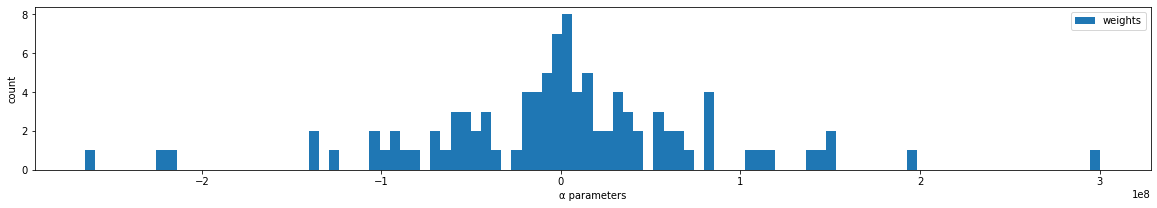

In [8]:
import pandas as pd
paper_weights = 10**7*pd.read_csv('1b_paper_potentials.txt', delimiter=' ')['αj'].values

print('Kernel Ridge: ', model.weights.numpy()[:4], '...')
print('Paper Weights:', paper_weights[:4], '...')

plt.figure(figsize=figsize, dpi=dpi)
plt.hist(model.weights.numpy(), bins=100, label="weights")
#plt.title("Distribution of weights")
plt.xlabel('α parameters')
plt.ylabel('count')
plt.legend()
plt.show()

## functional derivative

$$ \frac{1}{\Delta x} \nabla T^\text{ML}(\mathbf{n}) = \bar{T}\sum_{j=1}^{M}\alpha_j'(\mathbf{n}_j - \mathbf{n})k(\mathbf{n}_j, \mathbf{n}) = -\frac{1}{h} \sum_{j=1}^{M}\omega_j \gamma 2(\mathbf{n} - \mathbf{n}_j)k(\mathbf{n}_j, \mathbf{n})$$

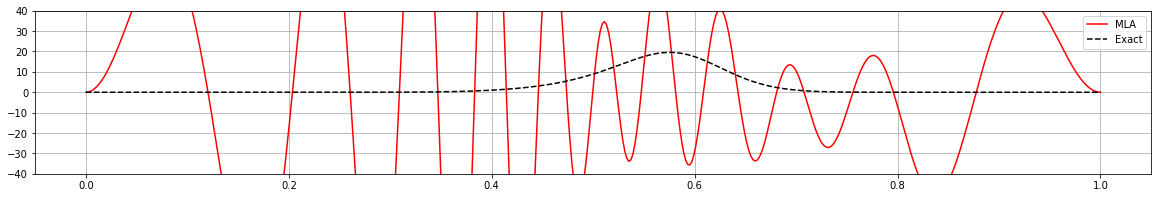

In [9]:
prediction_functional_derivative = model.functional_derivative(dataset_sample.density)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(dataset_sample.x, tf.transpose(prediction_functional_derivative), 'r', label='MLA')
plt.plot(dataset_sample.x, tf.transpose(dataset_sample.derivative), '--k', label='Exact')
plt.ylim([-40, 40])
plt.grid(True)
plt.legend(loc='best')
plt.show()

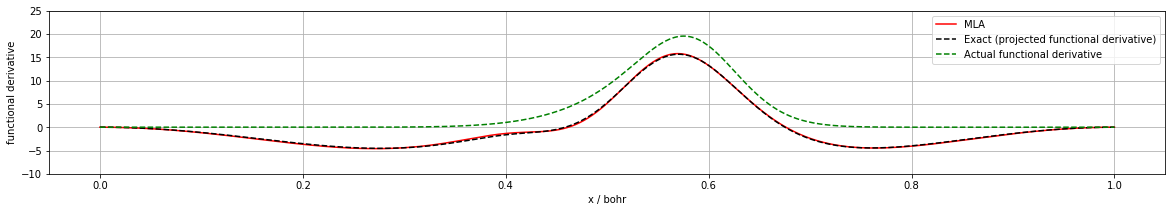

In [10]:
prediction_functional_derivative_proj = model.project(dataset_sample.density, prediction_functional_derivative)
derivative_proj =  model.project(dataset_sample.density, dataset_sample.derivative)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(dataset_sample.x, tf.transpose(prediction_functional_derivative_proj), 'r', label="MLA")
plt.plot(dataset_sample.x, tf.transpose(derivative_proj), '--k', label='Exact (projected functional derivative)')
plt.plot(dataset_sample.x, tf.transpose(dataset_sample.derivative), '--g', label='Actual functional derivative')
plt.ylim([-10, 25])
plt.xlabel('x / bohr')
plt.ylabel('functional derivative')
plt.legend(loc='best')
plt.grid()
plt.show()